## INTRODUCTION

In this assignment students have to make ARIMA model over shampoo salesdata and check the MSE between predicted and actual value.
Student can download data in .csv format from the following link:

https://datamarket.com/data/set/22r0/sales-of-shampoo-over-a-three-year-period#!ds=22r0&display=line


In [106]:
import pandas as pd
from pandas import datetime
import matplotlib.pyplot as plt
from statsmodels.tsa.arima_model import ARIMA, ARMAResults
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [11]:
# Read the dataset
series = pd.read_csv('shampoo-sales.csv', header=0, parse_dates=True, index_col='Month')
series.head()

,Sales of shampoo over a three year period
Month,
2015-01-01,266.0
2015-02-01,145.9
2015-03-01,183.1
2015-04-01,119.3
2015-05-01,180.3


In [16]:
# Data Analysis
series.count()

Sales of shampoo over a three year period    36
dtype: int64

#### PLOT THE SERIES

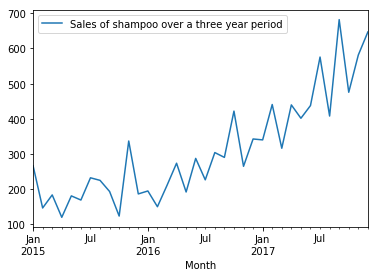

In [17]:
series.plot()

#### NOTE

Clearly the data is not stationary and the definetly there looks like a trend

#### DECOMPOSE THE PLOT

<Figure size 432x288 with 0 Axes>

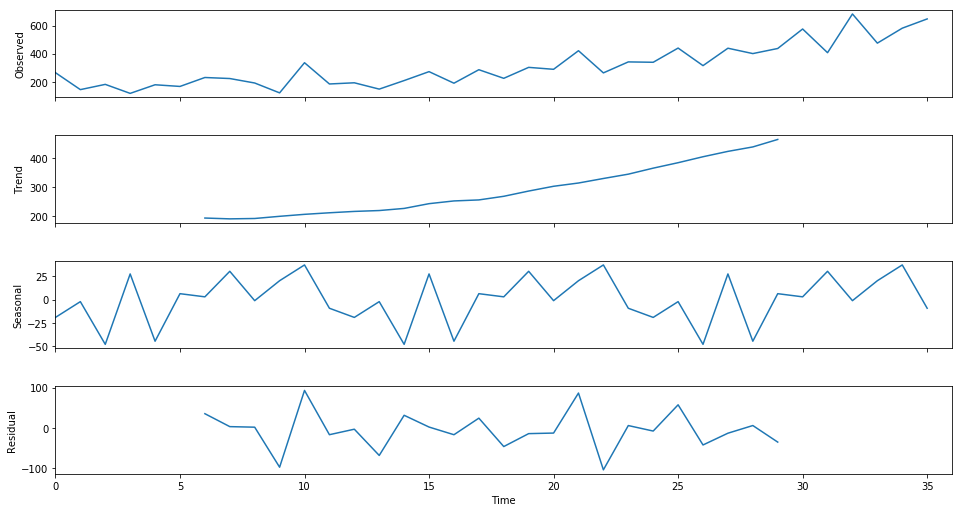

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose


decomposition = seasonal_decompose(series.dropna().values, freq=12)
fig = plt.figure()
fig = decomposition.plot()  
fig.set_size_inches(15, 8)

#### NOTE
Clearly there is a trend. So we can use ARIMA

#### DICKEY FULLER TEST

Make the data stationary.Determine the value of d

In [24]:
from statsmodels.tsa.stattools import adfuller
import statsmodels

In [25]:
# Create a function to get the p values
def stationary_check(timeseries):
    
    result = adfuller(timeseries)
    
    print ('Augumented Dikey-Fuller Test : ')
    labels = ['ADF Test Statistics', 'p-value', '#Lags Used', 'Number of Observations Used']

    for value, label in zip(result, labels):
        print (label + ' : ' + str(value))

    if result[1] < 0.05:
        print ("Null Hypothesis Rejected : Data is Stationary")
    else:
        print ("Null Hypothesis Not Rejected : Data is Non Stationary")

In [29]:
stationary_check(series.iloc[:, 0])

Augumented Dikey-Fuller Test : 
ADF Test Statistics : 3.0601420836411806
p-value : 1.0
#Lags Used : 10
Number of Observations Used : 25
Null Hypothesis Not Rejected : Data is Non Stationary


#### MAKING THE DATA STATIONARY

In [30]:
col_name = "diff_1"
series[col_name] = series["Sales of shampoo over a three year period"] - series["Sales of shampoo over a three year period"].shift(1)

In [31]:
series.head()

,Sales of shampoo over a three year period,diff_1
Month,,
2015-01-01,266.0,NaN
2015-02-01,145.9,-120.1
2015-03-01,183.1,37.2
2015-04-01,119.3,-63.8
2015-05-01,180.3,61.0


In [33]:
# REcheck for stationary
stationary_check(series.iloc[:, 1].dropna())

Augumented Dikey-Fuller Test : 
ADF Test Statistics : -7.249074055553854
p-value : 1.7998574141687034e-10
#Lags Used : 1
Number of Observations Used : 33
Null Hypothesis Rejected : Data is Stationary


### PLOT THE ACF AND THE PACF PLOTS

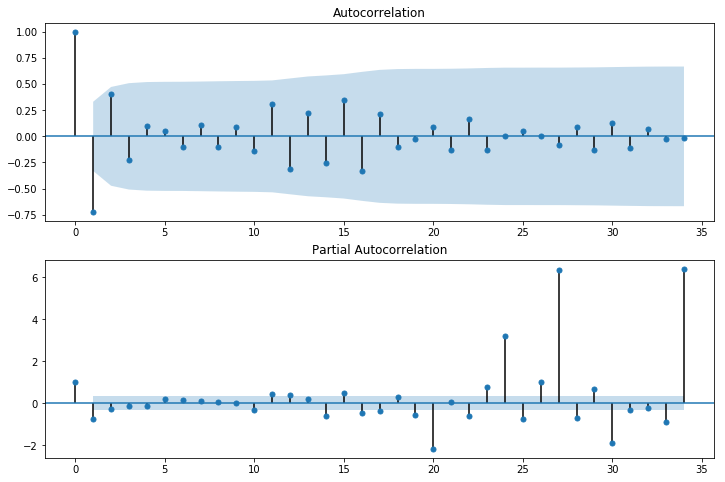

In [42]:
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(series.iloc[:,1].dropna(), ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(series.iloc[:,1].dropna(), ax=ax2)

#### NOTE


- p --> 2
- d --> 1
- q --> 0

### ARIMA

In [139]:
model = ARIMA(train["Sales of shampoo over a three year period"], order=(2,1,0))

In [140]:
# Split the dataset into train and test
train = series.loc['2015-01-01':'2016-12-01']
test = series.loc['2017-01-01':]

In [141]:
arima_results = model.fit()

In [142]:
print (arima_results.summary())

                                          ARIMA Model Results                                          
Dep. Variable:     D.Sales of shampoo over a three year period   No. Observations:                   23
Model:                                          ARIMA(2, 1, 0)   Log Likelihood                -129.182
Method:                                                css-mle   S.D. of innovations             65.567
Date:                                         Tue, 20 Aug 2019   AIC                            266.364
Time:                                                 17:15:46   BIC                            270.906
Sample:                                             02-01-2015   HQIC                           267.507
                                                  - 12-01-2016                                         
                                                        coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------

In [148]:
history = list(train["Sales of shampoo over a three year period"])
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(2,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(int(yhat))
    obs = test["Sales of shampoo over a three year period"][t]
    history.append(pd.Series(obs))
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=316.888881, expected=339.700000
predicted=337.349592, expected=440.400000
predicted=378.283529, expected=315.900000
predicted=413.320996, expected=439.300000
predicted=370.978216, expected=401.300000
predicted=425.757037, expected=437.400000
predicted=429.401354, expected=575.500000
predicted=474.580396, expected=407.600000
predicted=542.710028, expected=682.000000
predicted=480.813895, expected=475.300000
predicted=634.327314, expected=581.300000
predicted=561.051475, expected=646.900000


In [149]:
error = mean_squared_error(test["Sales of shampoo over a three year period"], predictions)
print('Test MSE: %.3f' % error)

Test MSE: 6048.683


In [153]:
test["Predict"] = predictions

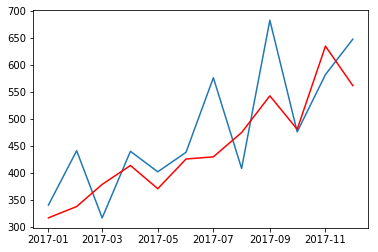

In [154]:
# plot
plt.plot(test["Sales of shampoo over a three year period"])
plt.plot(test["Predict"], color='red')

### AUTO ARIMA

In [122]:
import pmdarima as pm # 
model = pm.auto_arima(
    series["Sales of shampoo over a three year period"],
    start_p=1,
    start_q=1,
    max_p=10,
    max_q=10,
    d=1,
    start_P=0,
    seasonal=False,
    m=12,
    D=1,
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    transparams=False
    )
print(model.summary())

Fit ARIMA: order=(1, 1, 1); AIC=402.575, BIC=408.797, Fit time=0.049 seconds
Fit ARIMA: order=(0, 1, 0); AIC=430.873, BIC=433.984, Fit time=0.002 seconds
Fit ARIMA: order=(1, 1, 0); AIC=406.039, BIC=410.705, Fit time=0.028 seconds
Fit ARIMA: order=(0, 1, 1); AIC=409.013, BIC=413.679, Fit time=0.023 seconds
Fit ARIMA: order=(2, 1, 1); AIC=404.286, BIC=412.063, Fit time=0.044 seconds
Fit ARIMA: order=(1, 1, 2); AIC=401.525, BIC=409.302, Fit time=0.178 seconds
Fit ARIMA: order=(2, 1, 3); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 1, 2); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 1, 3); AIC=402.763, BIC=412.095, Fit time=0.312 seconds
Total fit time: 0.651 seconds
                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                   35
Model:                 ARIMA(1, 1, 2)   Log Likelihood                -1